In [8]:
import itertools

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import xarray as xr

import neuro_op as nop

In [9]:
nop.plot_setup()

In [10]:
def get_name(nn, run):
    return (
        "../testing/@MA0-neighbours/output2/"
        + "out"
        + "-nn"
        + str(nn)
        + "-run"
        + str(run)
        + ".h5"
    )


def get_mu(a, b):
    data = nop.import_hdf5(get_name(a, b), samples=True)
    return data["mu_nodes"]


def get_sd(a, b):
    data = nop.import_hdf5(get_name(a, b), samples=True)
    return data["sd_nodes"]


def get_kld(a, b):
    data = nop.import_hdf5(get_name(a, b), samples=True)
    return data["kl_divs"]


# Analytical functions for conjugate pairs


def sd_N(sd0, sd_in, N):
    """Returns analytically obtained sd of Normal conjugate pair after N data points with sd=sd_in"""
    return (sd0**-2 + N * sd_in**-2) ** -0.5


def KLD_PPD(mu1, mu2, sd1, sd2):
    """Returns analytically obatined KLD of two univariate Normal distributions"""
    return np.log(sd2 / sd1) + (sd1**2 + (mu1 - mu2) ** 2) / (2 * sd2**2) - 1 / 2


def get_ls(foo):
    ls = ""
    if foo == 1:
        ls = "--"
    elif foo < 1:
        ls = ":"
    else:
        ls = "-"
    return ls

In [11]:
# Parameter ranges used for simulations
N_nodes = 150
nn_arr = np.round(
    np.concatenate((np.arange(0, 16, 3), np.arange(30, 150, 30), [149])), 0
)
run_arr = np.arange(1, 11, 1)
t_arr = np.arange(0, len(get_kld(nn_arr[-1], run_arr[-1])), 1)

In [12]:
# Initialize xarray Dataset
tmp_arr = np.empty(
    (
        len(nn_arr),
        len(run_arr),
        len(t_arr),
        N_nodes,
    )
)
ds = xr.Dataset(
    {
        "mu": (("nn", "run", "time", "node"), np.empty_like(tmp_arr)),
        "sd": (("nn", "run", "time", "node"), np.empty_like(tmp_arr)),
        "kld": (("nn", "run", "time", "node"), np.empty_like(tmp_arr)),
    },
    coords={"nn": nn_arr, "run": run_arr, "time": t_arr, "node": np.arange(N_nodes)},
)
del tmp_arr

# Populate the Dataset
for nn, run in itertools.product(nn_arr[1:], run_arr):
    ds.mu.loc[dict(nn=nn, run=run)] = get_mu(nn, run)
    ds.sd.loc[dict(nn=nn, run=run)] = get_sd(nn, run)
    ds.kld.loc[dict(nn=nn, run=run)] = get_kld(nn, run)

nn = 0
foo = nop.import_hdf5(
    "../testing/@MA1-FirstBuilder/output3/out-N1-nn0-sd_llf1.0.h5", samples=True
)

ds.mu.loc[dict(nn=nn, run=1)] = foo["mu_nodes"][:1001]
ds.sd.loc[dict(nn=nn, run=1)] = foo["sd_nodes"][:1001]
ds.kld.loc[dict(nn=nn, run=1)] = foo["kl_divs"][:1001]

ds

<xarray.Dataset> Size: 396MB
Dimensions:  (nn: 11, run: 10, time: 1001, node: 150)
Coordinates:
  * nn       (nn) int64 88B 0 3 6 9 12 15 30 60 90 120 149
  * run      (run) int64 80B 1 2 3 4 5 6 7 8 9 10
  * time     (time) int64 8kB 0 1 2 3 4 5 6 7 ... 994 995 996 997 998 999 1000
  * node     (node) int64 1kB 0 1 2 3 4 5 6 7 ... 143 144 145 146 147 148 149
Data variables:
    mu       (nn, run, time, node) float64 132MB 0.0 0.0 ... -0.0405 -0.05564
    sd       (nn, run, time, node) float64 132MB 11.0 11.0 11.0 ... 1.018 1.019
    kld      (nn, run, time, node) float64 132MB 1.902 1.902 ... 0.001825

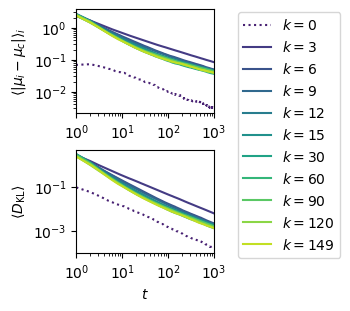

In [13]:
# Plot <KLD(t)>[nn]
# (Re)def. param.s
nn_arr = np.round(
    np.concatenate((np.arange(0, 16, 3), np.arange(30, 150, 30), [149])), 0
)
run_arr = np.arange(1, 11, 1)
time = ds.time.values

# Set up figure
colors = nop.get_colorcycle(len(nn_arr))
x = 1
y = 2
c = 1.5
fig, ax = plt.subplots(y, x, figsize=(1.5 * c * x, c * y))
for i in ax:
    i.set_prop_cycle(color=colors)

for nn in nn_arr:
    # <|mu_i-mu_x|>
    i = 0
    ax[i].plot(
        time,
        np.abs(ds.mu.sel(nn=nn)).mean(dim="node").mean(dim="run"),
        label="$k=$" + str(int(nn)),
        ls=get_ls(nn),
    )
    # <KLD>
    i = 1
    ax[i].plot(
        time,
        ds.kld.sel(nn=nn).mean(dim="node").mean(dim="run"),
        label="_$k=$" + str(int(nn)),
        ls=get_ls(nn),
    )

    # Delta Analysis, k-dep. KLD
#    i = 2
#    sd = sd_N(10, 1, time)
#    sd_PPD = (sd**2 + 1**2) ** 0.5
#    kld_N = np.log(sd_PPD) + 1 / (2 * sd_PPD**2) - 1 / 2
#    y_tmp = ds.kld.sel(nn=nn).mean(dim="node").mean(dim="run") - kld_N
#    ax[i].plot(
#        time,
#        y_tmp,
#        label="_$k=$" + str(int(nn)),
#        ls=get_ls(nn),
#    )

# Figure cosmetics
for i in ax[:2]:
    i.set_xlim((time[1], time[-1]))
    i.set_xscale("log")
    i.set_yscale("log")

# Labels and stuffs
ax[0].set_ylabel("$\langle |\mu_i-\mu_c|\\rangle_i$")
ax[1].set_ylabel("$\langle D_\\text{KL} \\rangle$")
ax[1].set_xlabel("$t$")
# ax[2].set_xlim(time[1], time[-1])
# ax[2].set_ylim(0, 0.1)


fig.legend(bbox_to_anchor=(1, 1), loc=2)

In [14]:
# fig.savefig("./fig/@MA-nn.pdf")